In [1]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use(["seaborn"])

TITLE_SIZE=12
TICK_SIZE=18
TICK_LABEL_SIZE=28
TEXT_SIZE=30

tex_fonts = {
    # Use LaTeX to write all text
    # "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": TICK_LABEL_SIZE,
    "font.size": TEXT_SIZE,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": TICK_SIZE,
    "xtick.labelsize": TICK_SIZE,
    "ytick.labelsize": TICK_SIZE, 
    "axes.titlesize": TITLE_SIZE
}

plt.rcParams.update(tex_fonts)

from plottify import autosize
import time
import os
import matplotlib as mpl

/tmp/ipykernel_2210642/3974954857.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(["seaborn"])


Guide for t-SNE https://distill.pub/2016/misread-tsne/

In [2]:
import os
import numpy as np
from sklearn.preprocessing import QuantileTransformer
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import sys
sys.path.append("..")
!pwd
# DANGER!!!
%cd /home/coppolillo/Desktop/RVAE/

import torch
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
CUDA=True
SEED=12121995
device = torch.device("cuda" if CUDA else "cpu")

from data_loaders import DataLoader, BprDataLoader
from models import MultiVAE, BPR
from util import naive_sparse2tensor, set_seed
set_seed(SEED)


/home/coppolillo/Desktop/RVAE/notebooks
/home/coppolillo/Desktop/RVAE


/home/coppolillo/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[ Using Seed :  12121995  ]


In [63]:
base_dir = "./"
datasets = ["pinterest", "ml-1m", "yahoo-r3", "citeulike-a", "amzn-ggf"]
datasets = sorted(datasets)

figures_dir = os.path.join(os.getcwd(), "figures")
pdf_dir = os.path.join(figures_dir, "pdf")
png_dir = os.path.join(figures_dir, "png")
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)
if not os.path.exists(pdf_dir):
    os.makedirs(pdf_dir)
if not os.path.exists(png_dir):
    os.makedirs(png_dir)
datasets


['amzn-ggf', 'citeulike-a', 'ml-1m', 'pinterest', 'yahoo-r3']

# Analyzing $BPR$

## Loading pre-trained model

In [64]:
n_items_dict = {"citeulike-a": 16875, "ml-1m": 3462, "pinterest": 9892, "yahoo-r3": 975}
n_users_dict = {"citeulike-a": 5551, "ml-1m": 6031, "pinterest": 55187, "yahoo-r3": 9735}

In [95]:
DATASET_IDX = 1
data_dir = "data"
model_dir = f"baseline_{str(SEED)}"
model_version = "S" if "oversampling" in model_dir else ""
model_path = os.path.join(data_dir, datasets[DATASET_IDX], "bpr", "results", model_dir)
DATASET_NITEMS = n_items_dict[datasets[DATASET_IDX]]
DATASET_NUSERS = n_users_dict[datasets[DATASET_IDX]]
LATENT_DIM= 32 

model = BPR(n_users=DATASET_NUSERS, n_items=DATASET_NITEMS, n_factors=LATENT_DIM)
model = model.to(device)
model.load_state_dict(torch.load(os.path.join(model_path, 'best_model.pth'), map_location=device))
model.eval()


BPR(
  (embed_user): Embedding(5551, 32)
  (embed_item): Embedding(16875, 32)
)

## Loading dataset

In [96]:
datasets[DATASET_IDX]

'citeulike-a'

In [97]:
trainloader = BprDataLoader(os.path.join(data_dir, datasets[DATASET_IDX], "data_bpr"), 
                         seed=SEED, decreasing_factor=1, model_type="baseline", model_name=model_dir)


phase 1: Loading data...
/home/coppolillo/Desktop/RVAE/data/citeulike-a/preprocessed_data/bpr/baseline_12121995/decreasing_factor_1/12121995
Loading pre-processed data from disk
Size:
train size = 994961
val tr size = 91744
val te size = 832
test tr size = 93429
test te size = 832
Done.


In [98]:
import pickle
with open(os.path.join(data_dir, datasets[DATASET_IDX], "data_bpr.pickle"), "rb") as f:
    data = pickle.load(f)

popularity = np.array(data["popularity"]) * trainloader.n_users #trainloader.absolute_item_popularity_dict["training"] #trainloader.item_popularity
pop, counts = np.unique(popularity, return_counts=True)

In [99]:
trainloader.n_users

5551

In [100]:
from scipy.signal import savgol_filter
from kneebow.rotor import Rotor

def find_elbow(data):
    rotor = Rotor()
    rotor.fit_rotate(data)

    return rotor.get_elbow_index()


def get_thresholds(x, y):
    # smoothing the curve
    window_size = max(5, len(y) // 5)
    
    polynomial_order = 2
    smoothed_y = savgol_filter(y, window_size, polynomial_order)
    
#     smoothed_model = np.poly1d(np.polyfit(x, y, ))
#     smoothed_y = smoothed_model(x)
    
    # computing derivatives
    y1 = np.diff(smoothed_y) / np.diff(x)
    y2 = np.diff(y1) / np.diff(x)[:-1]
    
    # searching the inflection point
    idx = np.abs(y2).argmin()
    
#     print(idx)

    left_x = x[:idx]
    left_y = smoothed_y[:idx]
    
    left_elbow = find_elbow(np.array(list(zip(left_x, left_y))))

    right_x = x[idx:]
    right_y = smoothed_y[idx:]
    
    right_elbow = find_elbow(np.array(list(zip(right_x, right_y))))

    low_thr_x = x[left_elbow]
    low_thr_y = y[left_elbow]

    high_thr_x = x[right_elbow + idx]
    high_thr_y = y[right_elbow + idx]
        

    return (low_thr_x, low_thr_y), (high_thr_x, high_thr_y)

In [11]:
to_plot = np.array([(x, y) for x, y in sorted(zip(pop, counts), key=lambda p: p[0])])


In [12]:
frequencies = np.cumsum(to_plot[:, 1][::-1])[::-1]

In [16]:
y = to_plot[:, 0]
x = frequencies
#x = -x+np.max(x)

ts = get_thresholds(x, y)

(low_thr_x, low_thr_y), (high_thr_x, high_thr_y) = ts

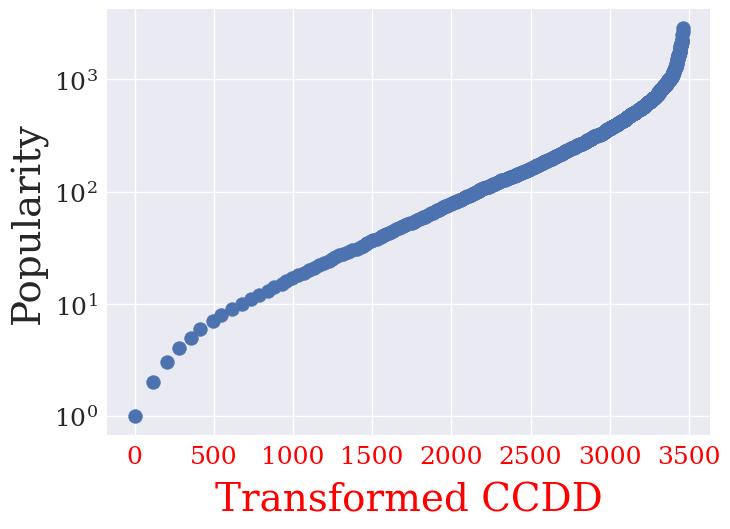

In [35]:
fig, ax = plt.subplots(figsize=(8,6))

linewidth = 5
    
#ax.scatter(to_plot[:, 0], to_plot[:, 1])
ax.scatter(to_plot[:, 0], frequencies, s=100)

#ax.scatter(x, y, s=20, color="red")
#ax.scatter(x_axis, y_axis)
ax.set_xscale("log")
ax.set_yscale("log")


ax.set_ylabel("Popularity")
ax.set_xlabel("Transformed CCDD", color="red", labelpad=10)
ax.tick_params(axis='x', colors='red')

#ax.set_xticks(ticks=np.arange(0,3501,1000),labels=[f"{num}k" if num!=0 else "0" for num in range(0,4,1)])

#ax.set_xlim(-20, 1020)
#secax.set_xlim(-20, 1020)

#ax.set_ylim(0, 30)

fig.tight_layout()

plt.show()

In [116]:
ts

((928.0, 15.0), (3203.0, 552.0))

In [117]:
nusers = data["users"] # len(data["training_data"])
f = data["popularity"] # data["popularity_dict"]["training"]
thresholds = data["thresholds"]
f = list(map(lambda x:x*nusers, f))

In [118]:
dist_x = list(range(len(f)))
dist_y = sorted(f)

dist_ts = get_thresholds(dist_x, dist_y)

(dist_low_thr_x, dist_low_thr_y), (dist_high_thr_x, dist_high_thr_y) = dist_ts

In [119]:
dist_ts

((232, 3.0), (3115, 459.0))

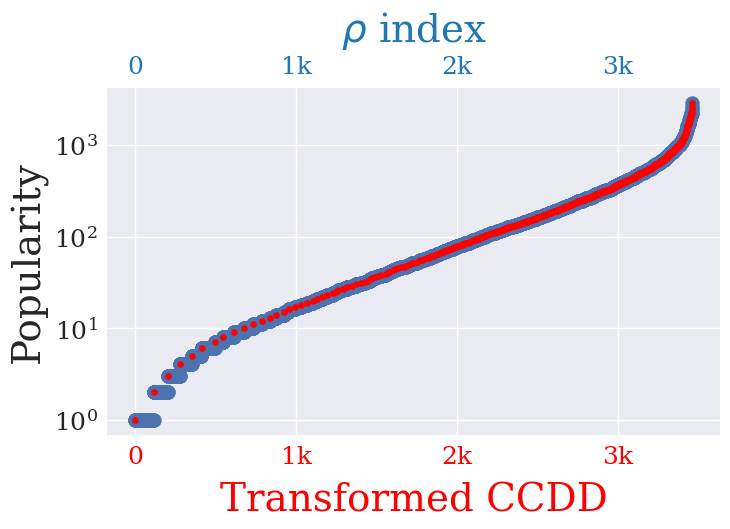

In [127]:
fig, ax = plt.subplots(figsize=(8,6))

linewidth = 5
    
#ax.scatter(to_plot[:, 0], to_plot[:, 1])
 #to_plot[:, 0], frequencies, s=100)


ax.scatter(dist_x, dist_y, s=100)#, color="darkblue")
ax.scatter(x, y, s=20, color="red")
#ax.scatter(x_axis, y_axis)
#ax.set_xscale("log")
ax.set_yscale("log")


secax = ax.secondary_xaxis('top', color="#1f77b4")
secax.set_xlabel(r'$\rho$ index', color="#1f77b4", labelpad=10)

ax.set_ylabel("Popularity")
ax.set_xlabel("Transformed CCDD", color="red", labelpad=10)
ax.tick_params(axis='x', colors='red')

ax.set_xticks(ticks=np.arange(0,3501,1000),labels=[f"{num}k" if num!=0 else "0" for num in range(0,4,1)])
secax.set_xticks(ticks=np.arange(0,3501,1000),labels=[f"{num}k" if num!=0 else "0" for num in range(0,4,1)])

#ax.set_xlim(-20, 1020)
#secax.set_xlim(-20, 1020)

#ax.set_ylim(0, 30)

fig.tight_layout()
fig.savefig(os.path.join(pdf_dir, f"{datasets[DATASET_IDX]}_cf_and_item_id.pdf"))
fig.savefig(os.path.join(png_dir, f"{datasets[DATASET_IDX]}_cf_and_item_id.png"))

plt.show()

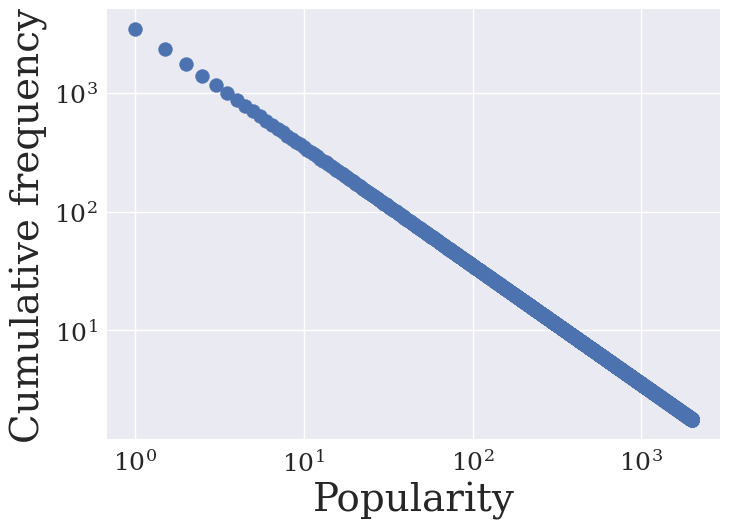

In [89]:
fig, ax = plt.subplots(figsize=(8,6))

linewidth = 5    
#ax.scatter(to_plot[:, 0], to_plot[:, 1])

a = 3501
c = 1
k = 1

linear_x = np.arange(1, 2001, 0.5, dtype=float)
linear_y = a * np.power(c*linear_x, -k)
#linear_y = np.cumsum(to_plot[:, 1][::-1])[::-1]
ax.scatter(linear_x, linear_y, s=100)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Popularity")
ax.set_ylabel("Cumulative frequency")


fig.tight_layout()
fig.savefig(os.path.join(pdf_dir, f"{datasets[DATASET_IDX]}_linear_cumulative_distribution.pdf"))
fig.savefig(os.path.join(png_dir, f"{datasets[DATASET_IDX]}_linear_cumulative_distribution.pdf.png"))

plt.show()
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

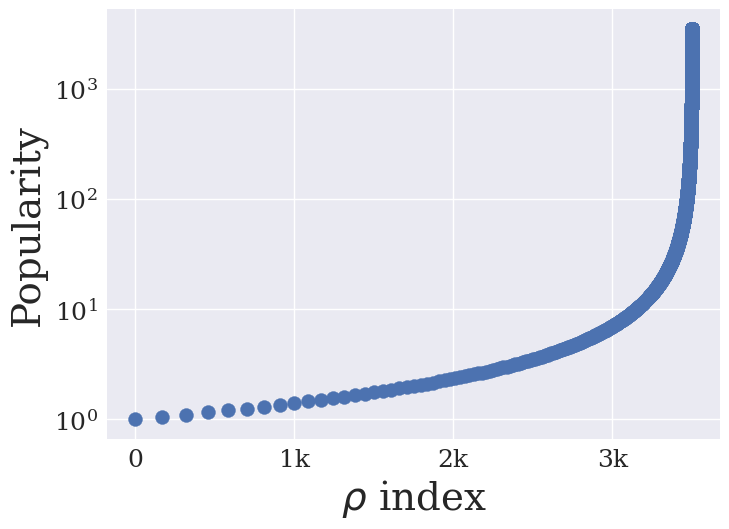

In [99]:
fig, ax = plt.subplots(figsize=(8,6))

linewidth = 5    

a = 3501
c = 1
k = 1

linear_x = np.arange(1, 3501, 0.05, dtype=float)
linear_y = a * np.power(c*linear_x, -k)
linear_y = (-linear_y + np.max(linear_y) + 1)
#linear_y = np.cumsum(to_plot[:, 1][::-1])[::-1]
ax.scatter(linear_y, linear_x, s=100)

plt.xticks(ticks=np.arange(0,3501,1000),labels=[f"{num}k" if num!=0 else "0" for num in range(0,4,1)])

#ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel(r"$\rho$ index")
ax.set_ylabel("Popularity")

fig.tight_layout()
fig.savefig(os.path.join(pdf_dir, f"{datasets[DATASET_IDX]}_linear_rho_index.pdf"))
fig.savefig(os.path.join(png_dir, f"{datasets[DATASET_IDX]}_linear_rho_index.png"))

plt.show()

In [71]:
colors

UsageError: %colors: you must specify a color scheme. See '%colors?'
